In [713]:
from __future__ import print_function, division
#Import BeautifulSoup
from bs4 import BeautifulSoup
#Regular expressions compiler
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import pickle

import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline
# %pylab inline

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [714]:
#Functions:

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [715]:
# with open('hosp.pickle','rb') as read_file:
with open('hosp3.pickle','rb') as read_file:
    hosp = pickle.load(read_file)
    
hosp.info()
hosp.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2378 entries, 0 to 2377
Data columns (total 9 columns):
avg_PRR                                                                2378 non-null float64
number_of_discharges                                                   2378 non-null float64
Case_Mix_Indexes                                                       2378 non-null float64
mortality_national_comparison_Same_as_the_national_average             2378 non-null uint8
safety_of_care_national_comparison_Same_as_the_national_average        2378 non-null uint8
patient_experience_national_comparison_Same_as_the_national_average    2378 non-null uint8
timeliness_of_care_national_comparison_Same_as_the_national_average    2378 non-null uint8
CRTFD_BED_CNT                                                          2378 non-null int64
FWIxMHI                                                                2378 non-null float64
dtypes: float64(4), int64(1), uint8(4)
memory usage: 120.8 KB


,avg_PRR,number_of_discharges,Case_Mix_Indexes,mortality_national_comparison_Same_as_the_national_average,safety_of_care_national_comparison_Same_as_the_national_average,patient_experience_national_comparison_Same_as_the_national_average,timeliness_of_care_national_comparison_Same_as_the_national_average,CRTFD_BED_CNT,FWIxMHI
0,16.9464,604.0,1.716075,0,0,0,0,420,32236.316813
1,15.1511,580.0,1.647400,0,0,1,0,235,32004.217875
2,15.1414,759.0,1.339850,0,0,1,0,240,31768.908312
3,15.7014,854.0,1.625075,0,0,0,0,358,30611.276469
4,16.7579,315.0,1.242825,1,0,0,0,100,25839.252500


### Continuous variable investigation - testing for linear assumptions

In [560]:
#Check correlation of continuous variables

# hosp1 = hosp.loc[:,['avg_PRR','number_of_discharges','Case_Mix_Indexes','FY_Wage_Index',
#                  '3_Year_Avg_Hourly_Wage','median_household_income','some_college_or_higher']]

# hosp1.corr()

In [561]:
# plt.figure(figsize=(7,5))
# sns.heatmap(hosp1.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [562]:
# sns.pairplot(hosp1);

NOTES:
- high correlation of 3-yr avg and wage index- probably won't include 3-yr avg since it has the weaker correlation with PRR
- none of the pairplots suggest a polynomial transformation

### Linear regression assumptions:
1. Regression is linear in parameters & correctly specified (Duke i)
2. The error terms are normally distributed and zero population mean (Duke iv)
3. The error term has constant variance $Var({\epsilon_i})={\sigma^2}$ for every i (Duke iii, no heteroskedasticity)
4. Errors are uncorrelated across observations: $cov({\epsilon_i},{\epsilon_j})=0$ for two observations i and j (Duke ii, no serial correlation)
5. No independent variable is a perfect linear function of any other independent variable (Duke i, no perfect multi-collinearity)

### Check model of continuous variables first with simple linear regression

In [563]:
# # Define the model
# # lm1 = smf.ols('weighted_avg_PRR ~ FY_2017_Wage_Index + Case_Mix_Indexes + median_household_income', data=hosp)
# lm1 = smf.ols('avg_PRR ~ Case_Mix_Indexes + number_of_discharges + FY_Wage_Index + median_household_income + some_college_or_higher', data=hosp)
# # Fit the model
# fit1 = lm1.fit()
# # Print summary statistics of the model's performance
# fit1.summary()

In [564]:
# Use statsmodels to plot the residuals vs the fitted values
# plt.figure(figsize=(12,8))
# plt.scatter(fit1.predict(), fit1.resid,alpha=0.1);

NOTES: poor R^2, residuals are clustered. Try investigating some to see if any features can be transformed (polynomials/interactions)

In [565]:
# #polynomial terms
# hosp['CMI2'] = hosp['Case_Mix_Indexes']**2
# hosp['nod2'] = hosp['number_of_discharges']**2
# hosp['FWI2'] = hosp['FY_Wage_Index']**2
# hosp['MHI2'] = hosp['median_household_income']**2
# hosp['SCH2'] = hosp['some_college_or_higher']**2
# #interactions
# hosp['CMIxNOD'] = hosp['Case_Mix_Indexes']*hosp['number_of_discharges']
# hosp['FWIxMHI'] = hosp['FY_Wage_Index']*hosp['median_household_income']
# hosp['MHIxSCH'] = hosp['median_household_income']*hosp['some_college_or_higher']
# hosp['CMIxSCH'] = hosp['Case_Mix_Indexes']*hosp['some_college_or_higher']

# lm2 = smf.ols('avg_PRR ~ Case_Mix_Indexes + number_of_discharges + FY_Wage_Index + median_household_income + some_college_or_higher + FWI2 + nod2 + MHI2 + SCH2 + CMIxNOD + FWIxMHI + MHIxSCH', data=hosp)
# # Fit the model
# fit2 = lm2.fit()
# # Print summary statistics of the model's performance
# fit2.summary()

NOTES: over 50% improvement with interaction and some polynomial terms but there is colinearity - check w/ VIF

### VIF

In [566]:
# #keep continuous variables for multicolinearity test
# # X_vif = hosp.loc[:,['number_of_discharges','Case_Mix_Indexes','FY_Wage_Index',
# #                     'median_household_income','some_college_or_higher']]
# # X_vif = hosp.loc[:,['number_of_discharges','Case_Mix_Indexes','FY_Wage_Index',
# #                     'median_household_income','some_college_or_higher'
# #                      ]]

# X_vif = hosp.loc[:,['number_of_discharges','FWIxMHI','CMIxSCH']]
# # 'FWI2', 'MHI2', 'SCH2','CMIxNOD', 'FWIxMHI', 'MHIxSCH'
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
# vif["features"] = X_vif.columns
# X_vif.info()

In [567]:
# vif.round(1)

### Split data into train/validate/test sets

,
                  'hospital_overall_rating_2','hospital_overall_rating_3','hospital_overall_rating_4',
                  'hospital_overall_rating_5','mortality_national_comparison_Below_the_national_average',
                  'mortality_national_comparison_Same_as_the_national_average','FWI2','MHI2','MHIxSCH'

In [568]:
# #drop data that is not for the model
# hosp = hosp.drop(['avg_ERR','avg_EXCESS',
#                   'number_of_readmissions','measure_name',
#                   'provider_id','start_date','end_date','hospital_name','state',
#                   'zip_code','county_name','hospital_type','county_st','3_Year_Avg_Hourly_Wage',
#                   'PRR_imputed','nod_imputed'
#                  ],axis=1)
# #drop the polynomials
# hosp = hosp.drop(['CMI2','nod2','FWI2', 'MHI2', 'SCH2'],axis=1)

# #drop the multicollinear variables
# hosp = hosp.drop(['FY_Wage_Index','median_household_income','some_college_or_higher','CMIxNOD','MHIxSCH'],axis=1)

# #drop nod
# hosp = hosp.drop(['number_of_discharges'],axis=1)

# #  'CMIxNOD', 'FWIxMHI', 'MHIxSCH'
# # hosp = hosp.drop(['CMI2','nod2','FWI2', 'MHI2', 'SCH2', 'CMIxNOD', 'FWIxMHI', 'MHIxSCH'],axis=1)

# # #drop all continuous variables except number of discharges 
# # hosp = hosp.drop(['avg_ERR','avg_EXCESS',
# #                   'number_of_readmissions','measure_name',
# #                   'provider_id','start_date','end_date','hospital_name','state',
# #                   'zip_code','county_name','hospital_type','county_st','3_Year_Avg_Hourly_Wage',
# #                   'PRR_imputed','nod_imputed','Case_Mix_Indexes','FY_Wage_Index',
# #                   'some_college_or_higher','median_household_income',
# #                   'CMI2','nod2','FWI2', 'MHI2', 'SCH2', 'CMIxNOD', 'FWIxMHI', 'MHIxSCH',
# #                  ],axis=1)
# # #drop hospital rating variables
# hosp = hosp.drop(['hospital_overall_rating_2','hospital_overall_rating_3','hospital_overall_rating_4','hospital_overall_rating_5'],axis=1)

# # #drop hospital ownership
# # hosp = hosp.drop(['hospital_ownership_Government__Hospital_District_or_Authority',
# #                  'hospital_ownership_Government__Local',
# #                  'hospital_ownership_Government__State',
# #                  'hospital_ownership_Physician',
# #                  'hospital_ownership_Proprietary',
# #                  'hospital_ownership_Voluntary_nonprofit__Church',
# #                  'hospital_ownership_Voluntary_nonprofit__Other',
# #                  'hospital_ownership_Voluntary_nonprofit__Private'],axis=1)

# # hosp = hosp.loc[:,['avg_PRR','number_of_discharges','Case_Mix_Indexes','FY_Wage_Index',
# #                    'some_college_or_higher','median_household_income',
# #                    'emergency_services_True','hospital_ownership_Government__Hospital_District_or_Authority',
# #                    'hospital_ownership_Government__Local',
# #                    'hospital_ownership_Government__State',
# #                    'hospital_ownership_Physician',
# #                    'hospital_ownership_Proprietary',
# #                    'hospital_ownership_Voluntary_nonprofit__Church',
# #                    'hospital_ownership_Voluntary_nonprofit__Other',
# #                    'hospital_ownership_Voluntary_nonprofit__Private',
# #                    'hospital_overall_rating_2','hospital_overall_rating_3','hospital_overall_rating_4','hospital_overall_rating_5',
# # ]]
# hosp.head(5)

In [716]:
X, y = hosp.iloc[:,1:], hosp['avg_PRR']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state = 9)

In [717]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state = 12)

### Run statsmodel regression on all variables (train+val data)

In [736]:
# lm3 = sm.OLS(y_train,X_train)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_check = pd.concat((scaler.fit_transform(X),y),axis=1)
all_columns = " + ".join(X_check.columns[:-1])

lm3 = smf.ols('avg_PRR ~' + all_columns, data=X_check)
# Fit the model
fit3 = lm3.fit()
# Print summary statistics of the model's performance
fit3.summary()

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

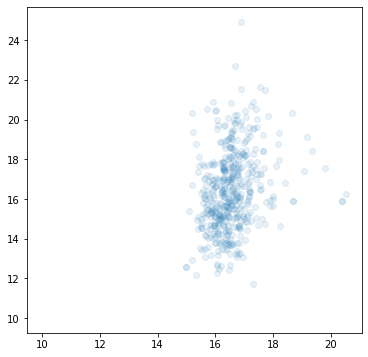

In [719]:
#predicted vs actual
test_set_pred_lm3 = fit3.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(test_set_pred_lm3, y_test, alpha=.1);
plt.plot(np.linspace(10,18,1), np.linspace(10,18,1));

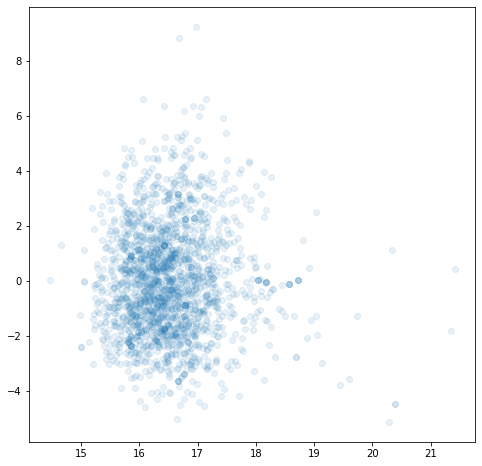

In [720]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(8,8))
plt.scatter(fit3.predict(), fit3.resid, alpha=0.1);

### Standardize

In [722]:
# #Standardize features
# std = StandardScaler()
# std.fit(X_train.values)

# X_tr = std.transform(X_train.values)

# X_te = std.transform(X_test.values)

# Only standardize non-categorical columns

#non-categorical columns
# col_names = ['number_of_discharges', 'Case_Mix_Indexes', 'FY_Wage_Index', 'median_household_income',
#              'some_college_or_higher','CMI2','nod2','FWI2','MHI2','SCH2','CMIxNOD', 'FWIxMHI', 'MHIxSCH']
# col_names = ['number_of_discharges', 'Case_Mix_Indexes', 'FY_Wage_Index', 'median_household_income',
#              'some_college_or_higher','CMIxNOD', 'FWIxMHI', 'MHIxSCH']
# col_names = ['number_of_discharges', 'Case_Mix_Indexes', 'FY_Wage_Index', 'median_household_income',
#              'some_college_or_higher','CMI2','nod2','SCH2','CMIxNOD', 'FWIxMHI']
# col_names=['number_of_discharges']
# col_names=[]
col_names = ['number_of_discharges','Case_Mix_Indexes','CRTFD_BED_CNT','FWIxMHI']

X_features = X[col_names]
X_train_features = X_train[col_names]
X_test_features = X_test[col_names]
X_val_features = X_val[col_names]

#pass through non-categorical columns
# ct = ColumnTransformer([
#         ('somename', StandardScaler(), ['number_of_discharges', 'Case_Mix_Indexes', 'FY_Wage_Index', 'median_household_income', 'some_college_or_higher','CMI2','nod2','FWI2','MHI2','SCH2','CMIxNOD', 'FWIxMHI', 'MHIxSCH'])], remainder='passthrough')
# ct = ColumnTransformer([
#         ('somename', StandardScaler(), ['number_of_discharges', 'Case_Mix_Indexes', 'FY_Wage_Index', 'median_household_income', 'some_college_or_higher','CMIxNOD', 'FWIxMHI', 'MHIxSCH'])], remainder='passthrough')
# ct = ColumnTransformer([
#         ('somename', StandardScaler(), ['number_of_discharges', 'Case_Mix_Indexes', 'FY_Wage_Index', 'median_household_income', 'some_college_or_higher','CMI2','nod2','SCH2','CMIxNOD', 'FWIxMHI'])
#     ], remainder='passthrough')
# ct = ColumnTransformer([
#         ('somename', StandardScaler(), ['number_of_discharges'])], remainder='passthrough')
# ct = ColumnTransformer([
#         ('somename', StandardScaler(), [])], remainder='passthrough')
ct = ColumnTransformer([
        ('somename', StandardScaler(), ['number_of_discharges','Case_Mix_Indexes','CRTFD_BED_CNT','FWIxMHI'])], remainder='passthrough')

ct.fit(X_train_features)

X_1 = ct.transform(X_features)
X_a = ct.transform(X_train_features)
X_b = ct.transform(X_test_features)
X_c = ct.transform(X_val_features)

#pull out the categorical from original data for concatenation with transformed
X_cat = np.array(X.drop(col_names,axis=1))
X_cat_train = np.array(X_train.drop(col_names,axis=1))
X_cat_test = np.array(X_test.drop(col_names,axis=1))
X_cat_val = np.array(X_val.drop(col_names,axis=1))

#concatenate back into one dataset
X_stan = np.concatenate((X_1,X_cat),axis=1) # full dataset
X_tr = np.concatenate((X_a,X_cat_train),axis=1)
X_te = np.concatenate((X_b,X_cat_test),axis=1)
X_va = np.concatenate((X_c,X_cat_val),axis=1)

# X_tr2 = pd.concat([X_a, X_cat_train], sort=False)
#
# X_a2 = pd.DataFrame(X_a,columns=col_names).reset_index().drop(['index'],axis=1)
# X_a3 = X_train.drop(col_names,axis=1).reset_index().drop(['index'],axis=1)
# X_a4 = X_a2.merge(X_a3, left_index=True, right_index=True)

In [723]:
# X_a4['effectiveness_of_care_national_comparison_Below_the_national_average'].value_counts()
# X_a4.info()

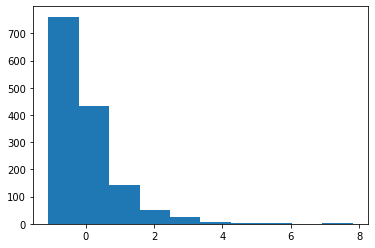

In [724]:
plt.hist(X_tr[:,2]);
# plt.hist(X_tr[:,19]);

### Ridge Regularization test

In [707]:
ridge_model = Ridge(alpha = 3) #found from manual validation alpha below
ridge_model.fit(X_tr, y_train)

list(zip(X_train.columns, ridge_model.coef_))

[('number_of_discharges', -0.047864708303020455),
 ('Case_Mix_Indexes', -0.6049215869980779),
 ('some_college_or_higher', 0.037615853142533275),
 ('mortality_national_comparison_Same_as_the_national_average',
  0.49725341153624236),
 ('safety_of_care_national_comparison_Same_as_the_national_average',
  0.17605916020427617),
 ('patient_experience_national_comparison_Same_as_the_national_average',
  -0.4791820822823012),
 ('timeliness_of_care_national_comparison_Same_as_the_national_average',
  -0.5184517706962574),
 ('CRTFD_BED_CNT', -0.3525508021789164),
 ('FWIxMHI', -0.4134258161617261)]

In [578]:
# Make predictions on the test set using the new model
test_set_pred_r = ridge_model.predict(X_te)

In [579]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred_r)

1.5137372336167825

In [580]:
r2_score(y_test, test_set_pred_r)

0.20887140384999936

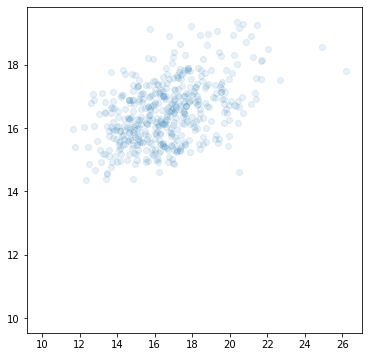

In [581]:
#actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, test_set_pred_r, alpha=.1);
plt.plot(np.linspace(10,20,1), np.linspace(10,20,1));

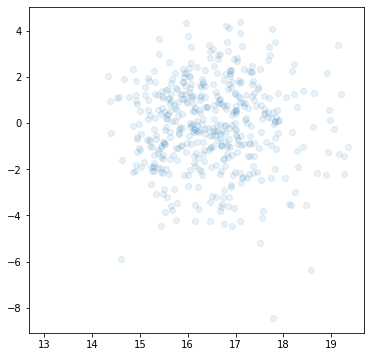

In [582]:
#predicted vs residuals
test_set_resid_r = test_set_pred_r-y_test
plt.figure(figsize=(6,6))
plt.scatter(test_set_pred_r, test_set_resid_r, alpha=.1);
plt.plot(np.linspace(13,18,1), np.linspace(-4,4,1));

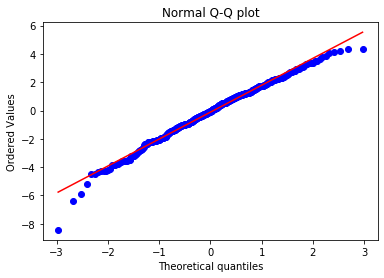

In [583]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(test_set_resid_r, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

### Lasso Regularization test

In [584]:
lasso_model = Lasso(alpha = 0.02)
lasso_model.fit(X_tr, y_train)

list(zip(X_train.columns, lasso_model.coef_))

[('number_of_discharges', 0.06611934583175684),
 ('mortality_national_comparison_Below_the_national_average',
  -0.22472380354906776),
 ('mortality_national_comparison_Same_as_the_national_average',
  -0.05460151153733593),
 ('safety_of_care_national_comparison_Below_the_national_average',
  -1.405895484115781),
 ('safety_of_care_national_comparison_Same_as_the_national_average',
  -1.1112292149870768),
 ('patient_experience_national_comparison_Below_the_national_average',
  0.28119348913783365),
 ('patient_experience_national_comparison_Same_as_the_national_average',
  -0.30742598571300495),
 ('timeliness_of_care_national_comparison_Below_the_national_average',
  1.0772019613307773),
 ('timeliness_of_care_national_comparison_Same_as_the_national_average',
  0.3899172931655141),
 ('FWIxMHI', 0.7748474955566974),
 ('CMIxSCH', 0.06899097245637481)]

In [585]:
# Make predictions on the test set using the new model
test_set_pred_l = lasso_model.predict(X_te)

In [586]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred_l)

1.5114640979870484

In [587]:
r2_score(y_test, test_set_pred_l)

0.2073820444122677

# cross validation to find alpha

### manually w/ Ridge

In [588]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
#     steps = [('standardize', StandardScaler()), 
#              ('lasso', Lasso(alpha = curr_alpha))]
#     steps = [('lasso', Lasso(alpha = curr_alpha))]   
    steps = [('ridge', Ridge(alpha = curr_alpha))]
  
    pipe = Pipeline(steps)
    pipe.fit(X_tr, y_train)
    
    val_set_pred = pipe.predict(X_va) #changed this to standardized X_va dataset
    err_vec_val[i] = mae(y_val, val_set_pred)

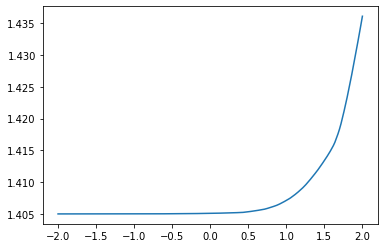

In [589]:
#plot the curve of validation error as alpha changes
plt.plot(np.log10(alphalist), err_vec_val);

In [590]:
np.min(err_vec_val)

1.404970306270287

In [591]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

0.01

### manually w/ Lasso

In [592]:
for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
#     steps = [('standardize', StandardScaler()), 
#              ('lasso', Lasso(alpha = curr_alpha))]
    steps = [('lasso', Lasso(alpha = curr_alpha))]   
#     steps = [('ridge', Ridge(alpha = curr_alpha))]
  
    pipe = Pipeline(steps)
    pipe.fit(X_tr, y_train)
    
    val_set_pred = pipe.predict(X_va) #changed this to standardized X_va dataset
    err_vec_val[i] = mae(y_val, val_set_pred)

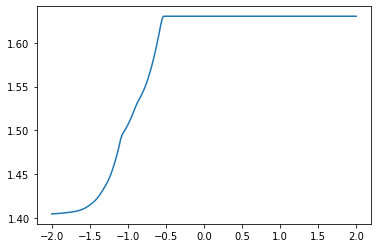

In [593]:
#plot the curve of validation error as alpha changes
plt.plot(np.log10(alphalist), err_vec_val);

In [594]:
np.min(err_vec_val)

1.404972352581983

In [595]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

0.01

# w/ Linear Regression

In [725]:
lm = LinearRegression()

lm.fit(X_tr,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [733]:
y_lm = lm.predict(X_te)

In [735]:
r2_score(y_lm,y_test)

-6.428531687437046

In [726]:
list(zip(X_train.columns,lm.coef_))

[('number_of_discharges', -0.05593031435228698),
 ('Case_Mix_Indexes', -0.1564975886699705),
 ('mortality_national_comparison_Same_as_the_national_average',
  0.524036868332119),
 ('safety_of_care_national_comparison_Same_as_the_national_average',
  -0.15353900450950578),
 ('patient_experience_national_comparison_Same_as_the_national_average',
  -0.5381215381993605),
 ('timeliness_of_care_national_comparison_Same_as_the_national_average',
  -0.4610752351581998),
 ('CRTFD_BED_CNT', -0.33672933713129255),
 ('FWIxMHI', -0.47424587919095323)]

### w/ RidgeCV

In [727]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
from sklearn.model_selection import GridSearchCV
alphavec = 10**np.linspace(-2,2,200)

a = {'alpha':alphavec}
ridge_model2 = GridSearchCV(Ridge(), param_grid=a, cv=5)
ridge_model2.fit(X_tr, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,...
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [728]:
# ridge_model2.alpha_
alpha_rm2 = ridge_model2.best_estimator_.alpha
alpha_rm2

23.81685551976158

In [729]:
list(zip(X_train.columns,ridge_model2.best_estimator_.coef_))

[('number_of_discharges', -0.039651687933092344),
 ('Case_Mix_Indexes', -0.14008220148666042),
 ('mortality_national_comparison_Same_as_the_national_average',
  0.5086726762857505),
 ('safety_of_care_national_comparison_Same_as_the_national_average',
  -0.1502281212944044),
 ('patient_experience_national_comparison_Same_as_the_national_average',
  -0.49533188159257097),
 ('timeliness_of_care_national_comparison_Same_as_the_national_average',
  -0.4141049885764852),
 ('CRTFD_BED_CNT', -0.31715907802719634),
 ('FWIxMHI', -0.4451651647482814)]

In [599]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
# list(zip(X_train.columns, ridge_model2.coef_))

In [600]:
# Make predictions on the test set using the new model
test_set_pred_r2 = ridge_model2.predict(X_te)

In [601]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred_r2)

1.5139714400626665

In [602]:
r2_score(y_test, test_set_pred_r2)

0.20890287781230577

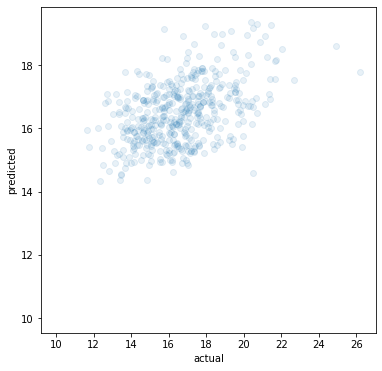

In [603]:
#ridge model - actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, test_set_pred_r2, alpha=.1);
plt.plot(np.linspace(10,18,1), np.linspace(10,18,1))
plt.xlabel('actual')
plt.ylabel('predicted');

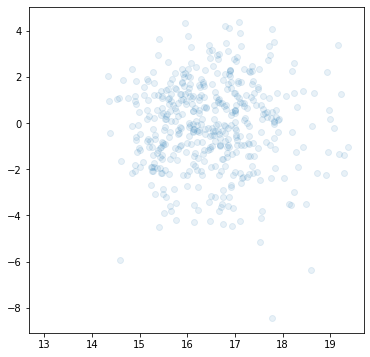

In [604]:
#predicted vs residuals
test_set_resid_r2 = test_set_pred_r2-y_test
plt.figure(figsize=(6,6))
plt.scatter(test_set_pred_r2, test_set_resid_r2, alpha=.1);
plt.plot(np.linspace(13,18,1), np.linspace(-4,4,1));

In [ ]:
explained_residual_variance_score

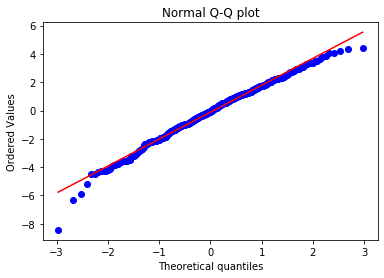

In [605]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(test_set_resid_r2, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

### w/ LassoCV

In [606]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-2,2,200)

# lasso_model2 = LassoCV(alphas = alphavec, cv=5)
# lasso_model2.fit(X_tr, y_train)

a = {'alpha':alphavec}
lasso_model2 = GridSearchCV(Lasso(), param_grid=a, cv=5)
lasso_model2.fit(X_tr, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.203...
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [607]:
alpha_lm2 = lasso_model2.best_estimator_.alpha
alpha_lm2

0.01

In [608]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
# list(zip(X_train.columns, lasso_model2.coef_))

In [609]:
# Make predictions on the test set using the new model
test_set_pred_l2 = lasso_model2.predict(X_te)

In [610]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred_l2)

1.5105965979959377

In [611]:
r2_score(y_test, test_set_pred_l2)

0.2102633201283084

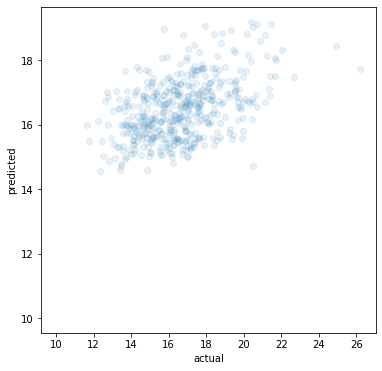

In [612]:
#lasso model - actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test,test_set_pred_l2, alpha=.1);
plt.plot(np.linspace(10,18,1), np.linspace(10,18,1))
plt.xlabel('actual')
plt.ylabel('predicted');

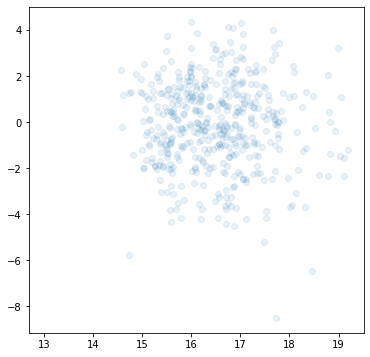

In [613]:
#predicted vs residuals
test_set_resid_l2 = test_set_pred_l2-y_test
plt.figure(figsize=(6,6))
plt.scatter(test_set_pred_l2, test_set_resid_l2, alpha=.1);
plt.plot(np.linspace(13,18,1), np.linspace(-4,4,1));

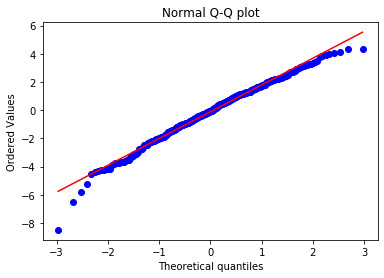

In [614]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(test_set_resid_l2, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [615]:
# Lars path visualization
# std = StandardScaler()
# std.fit(X_train.values)
# X_tr = std.transform(X_train.values)

## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')


Computing regularization path using the LARS ...


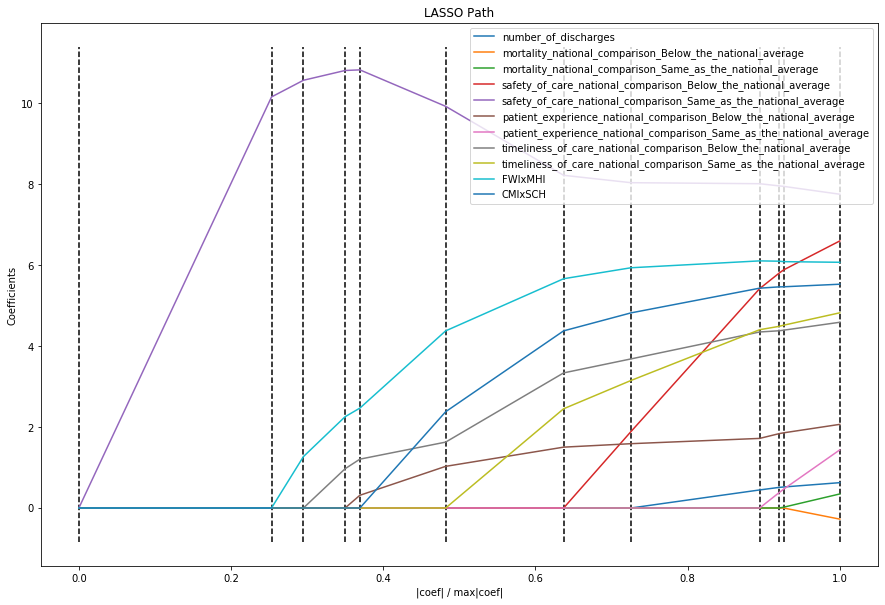

In [616]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(15,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns, loc = 'upper right')
plt.show()

### w/ Elastic Net

In [617]:
elnet_model2 = GridSearchCV(ElasticNet(), param_grid=a, cv=5)
elnet_model2.fit(X_tr, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1....
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scor

In [618]:
alpha_en2 = elnet_model2.best_estimator_.alpha
alpha_en2

0.01

In [619]:
# Make predictions on the test set using the new model
test_set_pred_e2 = elnet_model2.predict(X_te)

In [620]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred_e2)

1.5118635466066024

In [621]:
r2_score(y_test, test_set_pred_e2)

0.2087456302958468

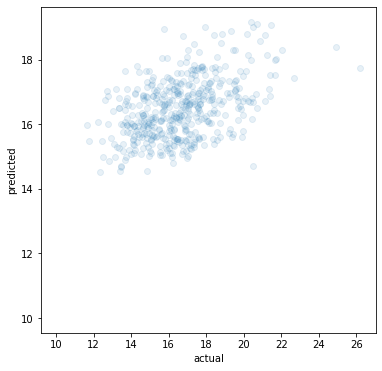

In [622]:
#lasso model - actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test,test_set_pred_e2, alpha=.1);
plt.plot(np.linspace(10,18,1), np.linspace(10,18,1))
plt.xlabel('actual')
plt.ylabel('predicted');

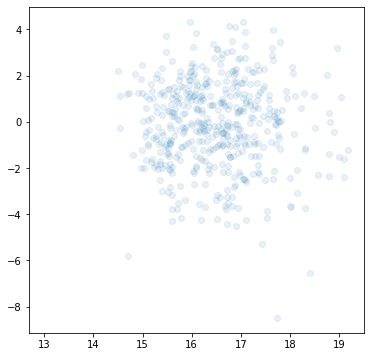

In [623]:
#predicted vs residuals
test_set_resid_e2 = test_set_pred_e2-y_test
plt.figure(figsize=(6,6))
plt.scatter(test_set_pred_e2, test_set_resid_e2, alpha=.1);
plt.plot(np.linspace(13,18,1), np.linspace(-4,4,1));

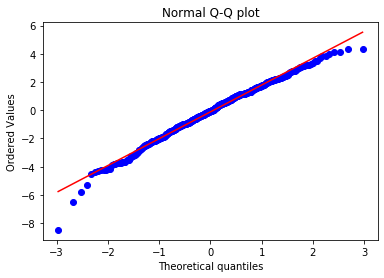

In [624]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(test_set_resid_e2, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

# Validate

# K Fold

In [625]:
lm = LinearRegression()
lm_ridge = Ridge(alpha=alpha_rm2)
lm_lasso = Lasso(alpha=alpha_lm2)
lm_elnet = ElasticNet(alpha=alpha_en2)

In [626]:
#Linear
cross_val_score(lm, X, y, # estimator, features, target
                cv=4, # number of folds 
                scoring='r2') # scoring metric

array([0.19920429, 0.24899786, 0.24437904, 0.1967278 ])

In [627]:
#Ridge
cross_val_score(lm_ridge, X_stan, y, # estimator, features, target
                cv=4, # number of folds 
                scoring='r2') # scoring metric

array([0.1999868 , 0.24832114, 0.24344082, 0.19733163])

In [628]:
#Lasso
cross_val_score(lm_lasso, X_stan, y, # estimator, features, target
                cv=4, # number of folds 
                scoring='r2') # scoring metric

array([0.20222013, 0.24168411, 0.23871606, 0.19703958])

In [629]:
#ElasticNet
cross_val_score(lm_elnet, X_stan, y, # estimator, features, target
                cv=4, # number of folds 
                scoring='r2') # scoring metric

array([0.20218362, 0.24260297, 0.23791251, 0.19764163])

In [630]:
kf = KFold(n_splits=4, shuffle=True, random_state = 71)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([0.26854666, 0.21665031, 0.19748452, 0.20657901])

In [631]:
kf = KFold(n_splits=5, shuffle=True)

print(f"Linear Regression mean val R^2: {np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')):.4f}")
print(f"Ridge Regression mean val R^2: {np.mean(cross_val_score(lm_ridge, X_stan, y, cv=kf, scoring='r2')):.4f}")
print(f"Lasso Regression mean val R^2: {np.mean(cross_val_score(lm_lasso, X_stan, y, cv=kf, scoring='r2')):.4f}")
print(f"Elastic Net Regression mean val R^2: {np.mean(cross_val_score(lm_elnet, X_stan, y, cv=kf, scoring='r2')):.4f}")

Linear Regression mean val R^2: 0.2200
Ridge Regression mean val R^2: 0.2167
Lasso Regression mean val R^2: 0.2205
Elastic Net Regression mean val R^2: 0.2177


In [632]:
# find coeffs:
lm_ridge.fit(X_stan,y)
lm_ridge.coef_

array([ 0.04727067, -0.29691985, -0.0938055 , -1.90938949, -1.38118183,
        0.29627909, -0.35782736,  1.16558407,  0.43251174,  0.99244782,
        0.2596151 ])

In [633]:
# find coeffs:
lm_ridge.fit(X_tr,y_train)
lm_ridge.coef_

array([ 0.04379067, -0.27172294, -0.06837706, -1.80318626, -1.37479174,
        0.29337525, -0.4515699 ,  1.24443006,  0.57971697,  0.95980707,
        0.29708503])

### Final validation set

In [634]:
#the model is fit well with train and test but very poorly with val - why?

lm_a = LinearRegression()
lm_a.fit(X_train,y_train)

print(f'Linear Regression val R^2 - train: {lm_a.score(X_train, y_train):.3f}')
print(f'Linear Regression val R^2 - val: {lm_a.score(X_val, y_val):.3f}')

Linear Regression val R^2 - train: 0.235
Linear Regression val R^2 - val: 0.220


In [635]:
#Ridge Regression
lm_ridge.fit(X_stan,y)
print(f'Ridge Regression v1 val R^2: {ridge_model.score(X_va, y_val):.3f}')
#GridSearchCV Ridge model
print(f'Ridge Regression v2 val R^2: {lm_ridge.score(X_va, y_val):.3f}')

Ridge Regression v1 val R^2: 0.220
Ridge Regression v2 val R^2: 0.235


In [636]:
#Lasso Regression
lm_lasso.fit(X_stan,y)
print(f'Lasso Regression v1 val R^2: {lasso_model.score(X_va, y_val):.3f}')
#GridSearchCV Lasso model
print(f'Lasso Regression v2 val R^2: {lm_lasso.score(X_va, y_val):.3f}')

Lasso Regression v1 val R^2: 0.219
Lasso Regression v2 val R^2: 0.235


In [637]:
#Elastic Net model
lm_elnet.fit(X_stan,y)
print(f'Elastic Net Regression v2 val R^2: {lm_elnet.score(X_va, y_val):.3f}')

Elastic Net Regression v2 val R^2: 0.234


# Check linear assumptions

### Residuals normally distributed with zero mean

In [638]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis

# data['predict']=fit.predict(X)
# data['resid']=data.cnt-data.predict
# with sns.axes_style('white'):
#     plot=data.plot(kind='scatter',
#                   x='predict',y='resid',alpha=0.2,figsize=(10,6))

In [639]:
# inspect histogram
# data.cnt.hist(bins=35)
# plt.title('Histogram of Dependent Variable (User Counts)');

In [640]:
# # diagnose/inspect residual normality using qqplot:
# stats.probplot(data['resid'], dist="norm", plot=plt)
# plt.title("Normal Q-Q plot")
# plt.show()

### Assumption 3: error terms must have constant variance

### Assumption 4: errors are uncorrelated across observations

### Assumption 5: no independent variable is a perfect linear function of any other independent variable (no perfect multi-collinearity)

In [641]:
#assume this is fixed with Ridge regression model

# Pick final coefficients and run with statsmodel

In [642]:
# lm3 = sm.OLS(y_train,X_train)
select_columns = all_columns

lm4 = smf.ols('avg_PRR ~' + select_columns, data=X_train_check)
# Fit the model
fit4 = lm4.fit()
# Print summary statistics of the model's performance
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_PRR   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     38.56
Date:                Wed, 09 Oct 2019   Prob (F-statistic):           8.44e-73
Time:                        17:03:40   Log-Likelihood:                -2798.3
No. Observations:                1392   AIC:                             5621.
Df Residuals:                    1380   BIC:                             5683.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              17.3699      0.306     56.755      0.000      16.770      17.970
number_of_discharges                                                    0.0001      0.000      0.710      0.478      -0.000       0.000
mortality_national_comparison_Below_the_national_average               -1.8582      0.187     -9.920      0.000      -2.226      -1.491
mortality_national_comparison_Same_as_the_national_average             -1.4125      0.149     -9.460      0.000      -1.705      -1.120
safety_of_care_national_comparison_Below_the_national_average           0.2902      0.111      2.614      0.009       0.072       0.508
safety_of_care_national_comparison_Same_as_the_national_average        -0.4582      0.138     -3.309      0.001      -0.730      -0.187
patient_experience_national_comparison_Below_the_national_average       1.2601      0.131      9.621      0.000       1.003       1.517
patient_experience_national_comparison_Same_as_the_national_average     0.5926      0.132      4.497      0.000       0.334       0.851
timeliness_of_care_national_comparison_Below_the_national_average       0.9680      0.143      6.770      0.000       0.687       1.248
timeliness_of_care_national_comparison_Same_as_the_national_average     0.3066      0.132      2.330      0.020       0.049       0.565
FWIxMHI                                                             -1.079e-05   2.19e-06     -4.926      0.000   -1.51e-05   -6.49e-06
CMIxSCH                                                                -0.0029      0.002     -1.162      0.246      -0.008       0.002
==============================================================================
Omnibus:                       44.597   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.086
Skew:                           0.447   Prob(JB):                     3.62e-11
Kurtosis:                       3.173   Cond. No.                     4.42e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Partial least squares

In [643]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=2, scale=False)
pls.fit(X_tr, y_train)

# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True,
#         tol=1e-06)
y_pred = pls.predict(X_te)

In [644]:
#R squared
pls.score(X_te,y_test)

0.14071846529999577

In [653]:
y_pred2 = y_pred[:,0]

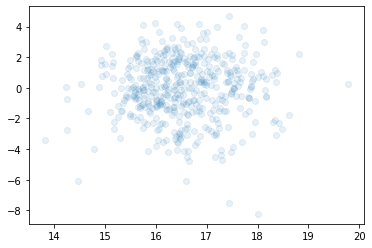

In [654]:
y_pred_resid = y_pred2-y_test
plt.scatter(y_pred2,y_pred_resid,alpha=0.1);

In [645]:
#exclude hospital overall rating
#continue feature engineering with interactions